# All-pole model prior $p(x,y)$

**Note:** The AP model should be considered *a special case* of the PZ model where the amplitudes $c$ are chosen in a very special way, and a rescaling parameter $g$ is introduced. In the PZ model the rescaling parameter is directly implicit in the amplitudes $c$.

## Model

Impulse response for $K$ poles $p_k = -\pi y_k + 2\pi i x_k$:

$$ h(t; p, g) = (t \geq 0) \times \sum_{k=1}^K c_k e^{p_k t} + c_k^* e^{p_k^* t}$$

Now each coefficient is not a free parameter, but immediately determined by the poles $p$ and the *gain* parameter $g$. They are determined by the special case that the numerator of the PZ degenerates to zero-th order polynomial in $x$. In other words, the transfer function can be written:

$$ \tilde{h}(x; p, g) \propto {1 \over \prod_{k=1}^K (2\pi i x - p_k)(2\pi i x - p_k^*)}$$

This still needs rescaling: the units don't make sense (it must have units of time -- **we use msec in our code**), and we know that the energy $\mathcal{E}(p, g) = \int h(t; p, g)^2 dt$ must be O(1) msec.

The normal procedure is to normalize using the pole product $N_p = \prod_{k=1}^K |p_k|^2$ such that the gain $|\tilde{h}(0; p, g)| = 1$ at DC, see e.g. Fulop 2011. But note that this is dimensionally inconsistent (it is unitless), and does not constrain $\mathcal{E}(p, g)$ in the way we want (in fact it will be too large). So, taking these hints seriously, we introduce the "extra" gain parameter $g$ such that the transfer function satisfies $\tilde{h}(0; p, g) = g$ (that's why we call it the gain). The full expression is therefore:

$$ \tilde{h}(x; p, g) = {g N(p) \over \prod_{k=1}^K (2\pi i x - p_k)(2\pi i x - p_k^*)}$$

From this it follows immediately the expression for the $c_k$ coefficients using partial fraction expansions. Here we use the "excluded pole product"

$$ c_k = \lim_{x \rightarrow p_k} (x - p_k) \tilde{h}(x; p, g) = {g N_p  \over \prod (p_k - p_1) (p_k - p_1^*) \ldots (p_k - p_k^*) \ldots (p_k - p_K) (p_k - p_K^*)} $$

Note that this is indeed dimensionless, as it should be.

See @Arfken2005 for a reference on partial fraction expansions (PFEs). We
simply use the limit formula.

In [2]:
%run init.ipy

from vtr.prior import bandwidth
from dgf import core
from lib import constants
from vtr.prior import allpole
from vtr import spectrum

2022-11-30 14:55:10.772481: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


## The prior for $g$: $p(g|p,E)$

We want to constrain $g$ such that the energy if the impulse response $\mathcal{E}(p, g) = \int h(t; p, g)^2 dt$ is equal to $E$ = O(1) msec.

We can reuse the analytic expression for $\mathcal{E}$ from the PZ model, since the AP model is just a special case of the PZ model:

$$ \mathcal{E}(p, g) = \sum_{ij=1}^{2K} \alpha_i \alpha_j S_{ij} := E$$

Since $\alpha_i \propto g$, this is quadratic in $g$. In other words, define $S(p)$ as

$$ \mathcal{E}(p, g) \equiv g^2 S(p)$$

where $S(p)$ only depends on the poles $p$ and has units [frequency]. Now the ME problem to be solved is trivial:

*Find $p(g|p,E)$ s.t. $$<\mathcal{E}> = \int dg\ \mathcal{E} p(g|p,E) = \int dg\ [g^2 S(p)] p(g|p,E) := E$$*

The solution is

$$ p(g|p,E) = N(0, \sigma_g^2)$$

where $\sigma_g^2 = E/S(p)$ which has units of [time/frequency] = [time²].

Note that the ME formalism does not imply that $h > 0$; $h \in \mathbb{R}$. So next to fixing the proper scale, and fixing the units, we also have gained an overall freedom in the polarity of the phase response by introducing $g$.

(And indeed, contrary to ME, we also tried a prior on $g^2 > 0$ which is $Exp(S_p/E)$, but it is actually less good as judged by $\log Z$ and the information $H$).

Just like the PZ case, we simply fix $E = 1\ msec$ and get good results. The convolution with samples generated from our source DGF prior are indeed O(1) in peak amplitude.

In [6]:
def samplexy(K = 3, prior = bandwidth.TFB_prior()):
    T, *xy = prior.sample(seed=jaxkey())
    x, y = np.split(np.array(xy), 2)
    x, y = x[:K], y[:K]
    return x, y

[Memory]1823.8s, 30.4min: Loading get_vtrformants_training_data...
[Memory]1824.9s, 30.4min: Loading run_nested...
[Memory]1825.7s, 30.4min: Loading run_nested...


energy [msec] = (0.6381092271842254, 0.638739404480616)


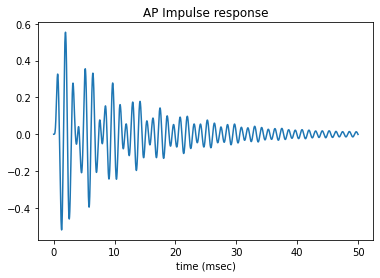

In [8]:
K = 3
x, y = samplexy(K)

fs = 1000 # kHz
dt = 1/fs # msec
t = np.arange(0., 50, dt) # msec

g = allpole.g_prior_ppf(rand(), x, y)

h = allpole.impulse_response(t, x, y, g)
plot(t, h)
title("AP Impulse response")
xlabel("time (msec)")

# Calculate energy numerically and compare with analytical result
energy = np.dot(h, h)*dt
print("energy [msec] =", (energy, allpole.impulse_response_energy(x, y, g)))

Test if the expected values $<\mathcal{E}>$ is close to its prescribed value $E = 1\ msec$. There is a larger spread compared to PZ model, and much more mass on small values of $g They both look like Gamma distributions.

(0.9882815341301965, 1.37809984452792)

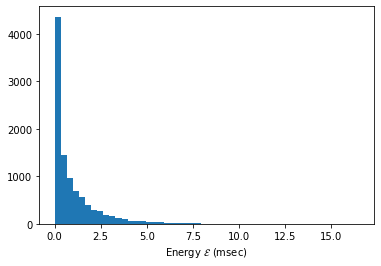

In [11]:
energies = []
for _ in range(10000):
    g = allpole.g_prior_ppf(rand(), x, y)
    energies += [allpole.impulse_response_energy(x, y, g)]

hist(energies, bins=50)
xlabel("Energy $\mathcal{E}$ (msec)")
mean(energies), std(energies) # msec

## The AP power spectrum

(-45.66754277341089, -36.12359947967774)

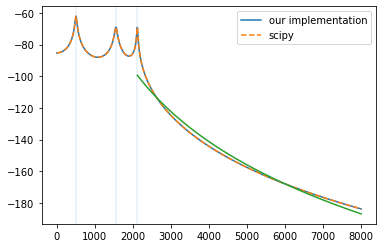

In [20]:
K = 3
x, y = samplexy()
g = allpole.g_prior_ppf(rand(), x, y)

f = constants.spectrum_frequencies(constants.TIMIT_FS_HZ)
power = allpole.transfer_function_power_dB(f, x, y, g)
plot(f, power, label="our implementation")
for xi in x: axvline(xi, alpha=.1)

### Compare with Scipy implementation
import scipy.signal

poles = -np.pi*y + 2*np.pi*(1j)*x
p = hstack([poles, conj(poles)])
k = prod(abs(p))

w, H = scipy.signal.freqresp(([], p, k), 2*pi*f)
plot(f, 20*log10(abs((g/1000)*H)), "--", label="scipy")

legend()
####

F3 = x[-1]
tilt, interp = spectrum.fit_tilt(f, power, return_interp=True, cutoff=F3)
plot(f[f>F3], interp(f[f>F3]))
tilt, allpole.analytical_tilt(K)

### AP model as a special case of PZ

The PZ model includes the AP model as a special case, when the amplitudes $(a,b)$ take on specific values. The spectral tilt is then much lower than the usual -6 dB/oct (for large $x$).

[ 0.00137896 -0.00232814  0.00094918 -0.16397157  0.09090582 -0.0047798 ]


-44.787439783623924

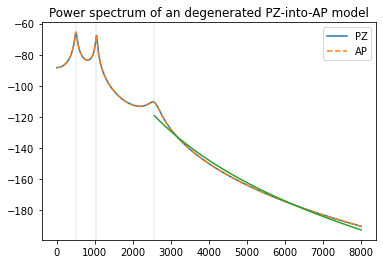

In [39]:
from vtr.prior import polezero

K = 3
x, y = samplexy(K)
g = allpole.g_prior_ppf(rand(), x, y)

# Calculate the amplitudes `ab_AP` that turn the PZ into an AP
c = allpole.pole_coefficients(x, y, g)
ab_AP = polezero.amplitudes(c) # convert to (cos, sin) real amplitudes
print(ab_AP)

# Plot the transfer functions and verify that they're equal
power = polezero.transfer_function_power_dB(f, x, y, ab_AP)
plot(f, power, label="PZ")
for xi in x: axvline(xi, alpha=.1)

plot(f, allpole.transfer_function_power_dB(f, x, y, g), '--', label="AP")
legend()
title("Power spectrum of an degenerated PZ-into-AP model")

# Fit tilt
F3 = x[-1]
tilt, interp = spectrum.fit_tilt(f, power, return_interp=True, cutoff=F3)
plot(f[f>F3], interp(f[f>F3]))
tilt

But does the $p(a,b|p,E)$ prior place any mass at that specific point? **Yes!** This is totally by virtue of the $g$ parameter, because it scales the $(a, b)$ amplitudes back "into reach" of the typical set of $p(a,b|p,\mu^2)$.

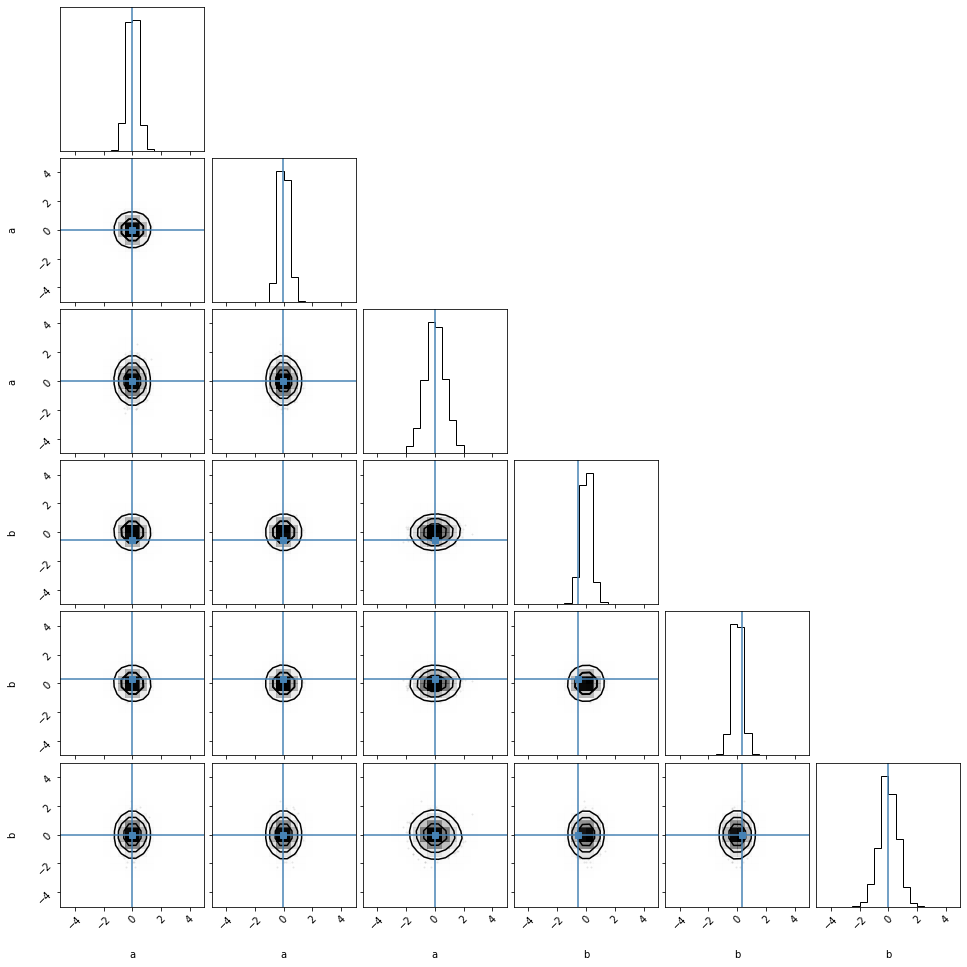

In [57]:
# Visualize the "AP" point of the PZ amplitudes given the poles
K = 3
x, y = samplexy(K)
g = allpole.g_prior_ppf(rand(), x, y)
c = allpole.pole_coefficients(x, y, g)
ab_AP = polezero.amplitudes(c) # convert to (cos, sin) real amplitudes

ab_samples = polezero.amplitudes_prior_ppf(rand(2*K, 1000), x, y).T

corner.corner(
    ab_samples,
    range = itertools.repeat((-5, 5), 2*K),
    labels = [*["a"]*K, *["b"]*K],
    smooth = 1.,
    truths = ab_AP
);

This suggests that the PZ model, while nominally limited to -6 dB/oct tilt for large $x$, can actually model a range of spectral tilts within $[0, f_s/2]$, since it can model (i.e. its amplitudes have non-neglible mass at) produce the -36 dB/octave tilt characteristic of the AP. And indeed, this is confirmed in the next plot (note that the tilt measurement is +/- 6 dB accuracy).

CPU times: user 4min 36s, sys: 129 ms, total: 4min 36s
Wall time: 4min 39s


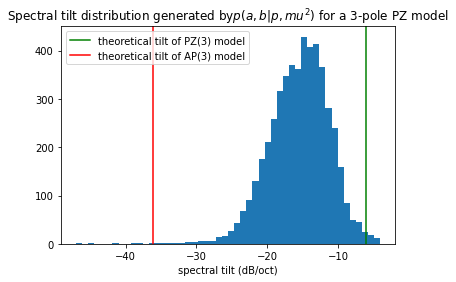

In [53]:
%%time
tilts = []

K = 3
f = constants.spectrum_frequencies(constants.TIMIT_FS_HZ)

for i in range(5000):
    x, y = samplexy()
    ab = polezero.amplitudes_prior_ppf(rand(2*K), x, y)
    power = polezero.transfer_function_power_dB(f, x, y, ab)
    
    F, B = spectrum.get_formants_from_spectrum(f, power)
    tilts += [spectrum.fit_tilt(f, power, cutoff=F[-1])]

hist(tilts, bins=50);
axvline(polezero.analytical_tilt(), color="green", label="theoretical tilt of PZ(3) model")
axvline(allpole.analytical_tilt(3), color="red", label="theoretical tilt of AP(3) model")
title("Spectral tilt distribution generated by$ p(a,b|p,mu^2)$ for a 3-pole PZ model")
xlabel("spectral tilt (dB/oct)")
legend();
mean(tilts)

Yet another angle is quantifying how much the constraint $\alpha = (a, b) \rightarrow \alpha_{AP} = (a_{AP}, b_{AP})$ is worth in terms of information. This can be done by simply calculating the standard KL divergence between the 2 multivariate Gaussians:

$$ D_{KL}(\delta(\alpha - \alpha_{AP})|N(\alpha|0, \Sigma)) = \infty $$

Here $\Sigma = {E \over 2K} S(p)^{-1}$ (see polezero.ipynb).

So in practice we relax the problem (like we did in calculating the density $p(u)$) where we add a "tolerance" for the amplitudes, which determines our precision -- how close should an $\alpha \sim N(0, \Sigma)$ be to $\alpha_{AP}$ to be reckoned "close"?

Since we are directly in the amplitude domain, it is reasonable to take the noise floor power $\delta_n^2$ as the tolerance (in fact, the square root of it). So we relax the following way

$$ \delta(\alpha - \alpha_{AP}) \rightarrow N(\alpha|\alpha_{AP}, \delta_n^2 I_{2K}) $$

This yields an analytical formula for $D_{KL}(N_{AP}|N_{PZ})$.

The resulting distribution of $D_KL$'s for $x,y \sim p(F,B)$ and $g \sim p(g|p,E)$ are heavy-tailed, so we plot medians and IQRs for them. In general we see that
- The KL divergences in bans are perhaps a bit larger than hoped (given $\delta_n^2 = -60\ dB$, and since they grow linearly as $K$, finding the AP model in the PZ parameter space becomes rapidly impossible (at least at the given tolerance).
- The *difference* in KL divergence between an AP model *with* $g \sim p(g|p,E)$ and an AP model *without* $g$ (i.e. $g := 1$) are **independent** of $\delta^2_n$ and are enormous. So here is yet another reason why $g$ is extremely important.

Tolerance (amplitude): 0.001


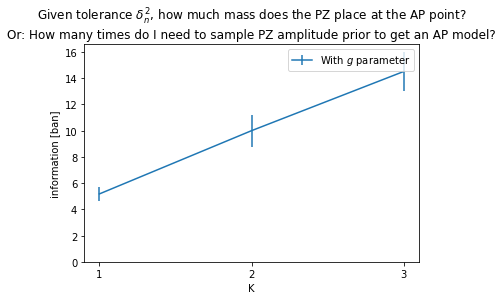

CPU times: user 6.12 s, sys: 156 ms, total: 6.28 s
Wall time: 6.08 s


Text(0.5, 1.0, 'Independent of tolerance $\\delta_n^2$: how much more do I need to sample PZ amplitude prior to get an AP model?')

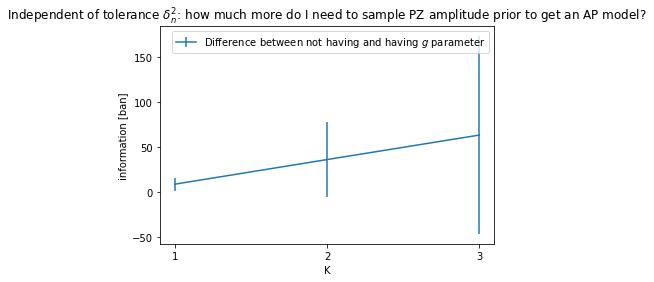

In [162]:
%%time
# Very slow
from lib import util

def kldiv_AP_PZ(x, y, g, delta2, E_msec = 1.):
    E = len(x)
    E = E_msec/1000.
    S = polezero.overlap_matrix(x, y)
    precision_matrix = (2*K)/E*S
    
    c = allpole.pole_coefficients(x, y, g)
    ab_AP = polezero.amplitudes(c) # convert to (cos, sin) real amplitudes
    
    # Using an analytic formula, but this is just KL(MVN0, MVN1)
    KL_nats = 0.5*(\
        2*K/E*delta2*np.trace(S) +\
        2*K/E*ab_AP.T @ S @ ab_AP +\
        (-2*K) +\
        2*K*np.log(E/(2*K)) - np.linalg.slogdet(S)[1] - 2*K*np.log(delta2)
    )
    
    return util.nats_to_ban(KL_nats) # ban

nsamp = 50
Ks = (1, 2, 3)
delta2 = constants.NOISE_FLOOR_POWER
print("Tolerance (amplitude):", sqrt(delta2))

KLs = np.zeros((nsamp, len(Ks)))
KLs_noscaling = np.zeros((nsamp, len(Ks)))
    
for j, K in enumerate(Ks):
    for i in range(nsamp):
        x, y = samplexy(K)
        g = allpole.g_prior_ppf(rand(), x, y)

        KLs[i, j] = kldiv_AP_PZ(x, y, g, delta2)
        KLs_noscaling[i, j] = kldiv_AP_PZ(x, y, 1., delta2)
    
# Plot the bans for AP with g
errorbar(Ks, np.median(KLs, axis=0), scipy.stats.iqr(KLs, axis=0), label="With $g$ parameter")
legend()
xlabel("K")
xticks(Ks)
ylabel("information [ban]")
ylim(0, None)
title("Given tolerance $\delta_n^2$, how much mass does the PZ place at the AP point?\nOr: How many times do I need to sample PZ amplitude prior to get an AP model?");
show()

# Plot the difference in bans: how many times extra do we need to sample
# if we don't use g as an extra parameter?
# **This is independent of the tolerance delta²_n**
errorbar(Ks, np.median(KLs_noscaling - KLs, axis=0), scipy.stats.iqr(KLs_noscaling - KLs, axis=0), label="Difference between not having and having $g$ parameter")
legend()
xlabel("K")
xticks(Ks)
ylabel("information [ban]")
title("Independent of tolerance $\delta_n^2$: how much more do I need to sample PZ amplitude prior to get an AP model?");

## Fitting the TFB samples

In [156]:
%%time
samples = bandwidth.get_TFB_samples()

[Memory]10138.4s, 169.0min: Loading get_TFB_samples...
CPU times: user 77.5 ms, sys: 9.95 ms, total: 87.5 ms
Wall time: 130 ms


In [9]:
fitted = allpole.get_fitted_TFB_samples()

[Memory]29.6s, 0.5min   : Loading get_TFB_samples...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading run_nested...
[Memory]29.6s, 0.5min   : Loading r

In [10]:
K = 10
sample_index = 40

def getfit(K, sample_index):
    return fitted[(K-3)*50+sample_index]

fit = getfit(K, sample_index)

sample = fit['sample']
results = fit['results']

In [214]:
K=4
sample = samples[11]

results = allpole.fit_TFB_sample(sample, K, 1111111222222)

________________________________________________________________________________
[Memory] Calling vtr.prior.allpole.run_nested...
run_nested(1111111222222, {'bootstrap': 10, 'nlive': 27, 'sample': 'rslice'}, {'maxcall': 10000000, 'save_bounds': False})


671it [03:46,  2.96it/s, +27 | bound: 69 | nc: 1 | ncall: 46593 | eff(%):  1.499 | loglstar:   -inf < -25.180 <    inf | logz: -46.252 +/-    nan | dlogz:  0.001 >  0.036] 

_____________________________________________________run_nested - 227.2s, 3.8min


Summary
nlive: 27
niter: 671
ncall: 46566
eff(%):  1.499
logz: -46.252 +/-  0.836


None

'Information (bans)'

7.716726194690923

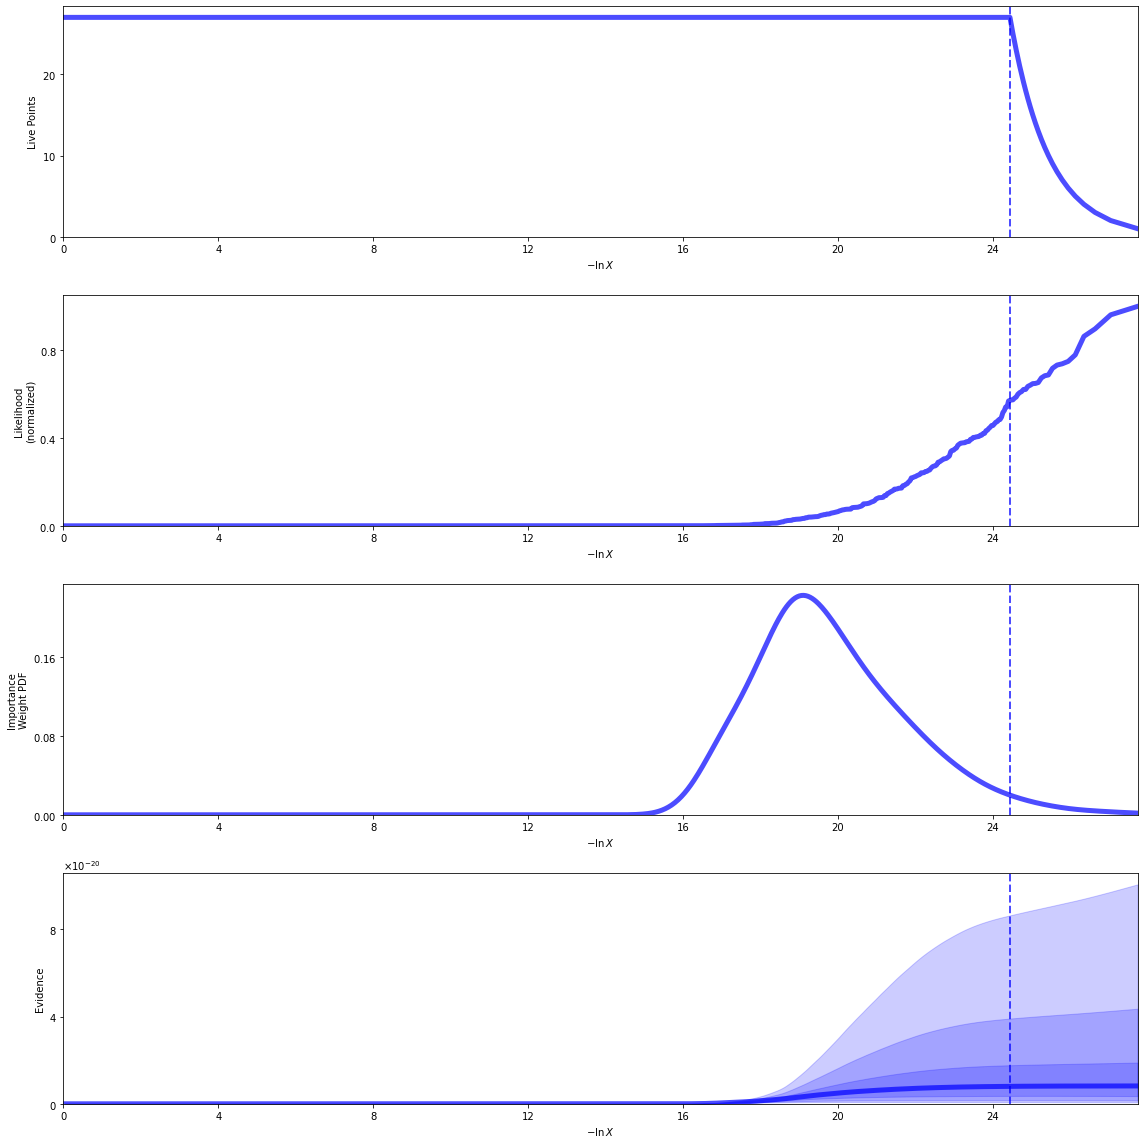

Quantiles:
x [(0.025, 893.2999287324482), (0.5, 902.1130989303238), (0.975, 912.6918945614198)]
Quantiles:
x [(0.025, 933.6774631346726), (0.5, 1021.2911689414863), (0.975, 1097.9670785103024)]
Quantiles:
x [(0.025, 1558.2219683523172), (0.5, 1575.0861955433427), (0.975, 1598.8467686436777)]
Quantiles:
x [(0.025, 2874.338242143593), (0.5, 2903.7529572367084), (0.975, 2932.7804948632174)]
Quantiles:
y [(0.025, 69.4044274249503), (0.5, 88.21379609066767), (0.975, 108.75719657373243)]
Quantiles:
y [(0.025, 2759.136671222858), (0.5, 4380.684995586432), (0.975, 4968.938963583447)]
Quantiles:
y [(0.025, 34.91717043867945), (0.5, 69.11344752730625), (0.975, 109.09721262830242)]
Quantiles:
y [(0.025, 128.31372378136476), (0.5, 162.6320704015848), (0.975, 199.57856192529)]
Quantiles:
g [(0.025, -0.11204629106578322), (0.5, 0.012347925396977917), (0.975, 0.134065209795924)]


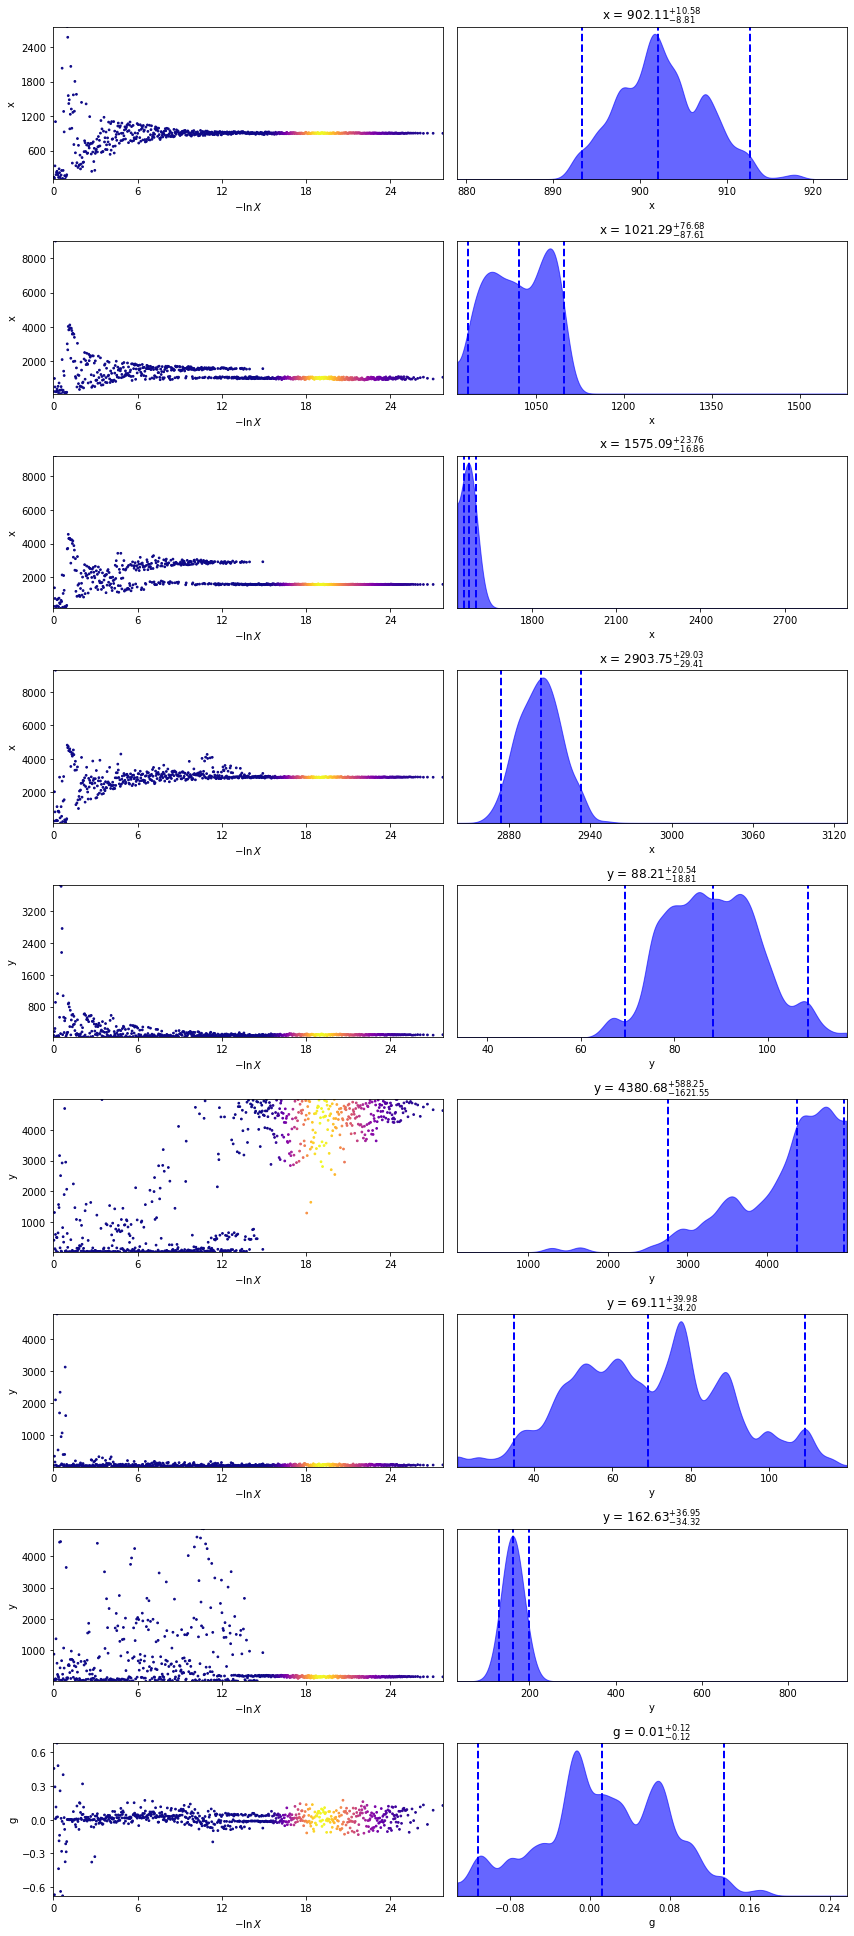

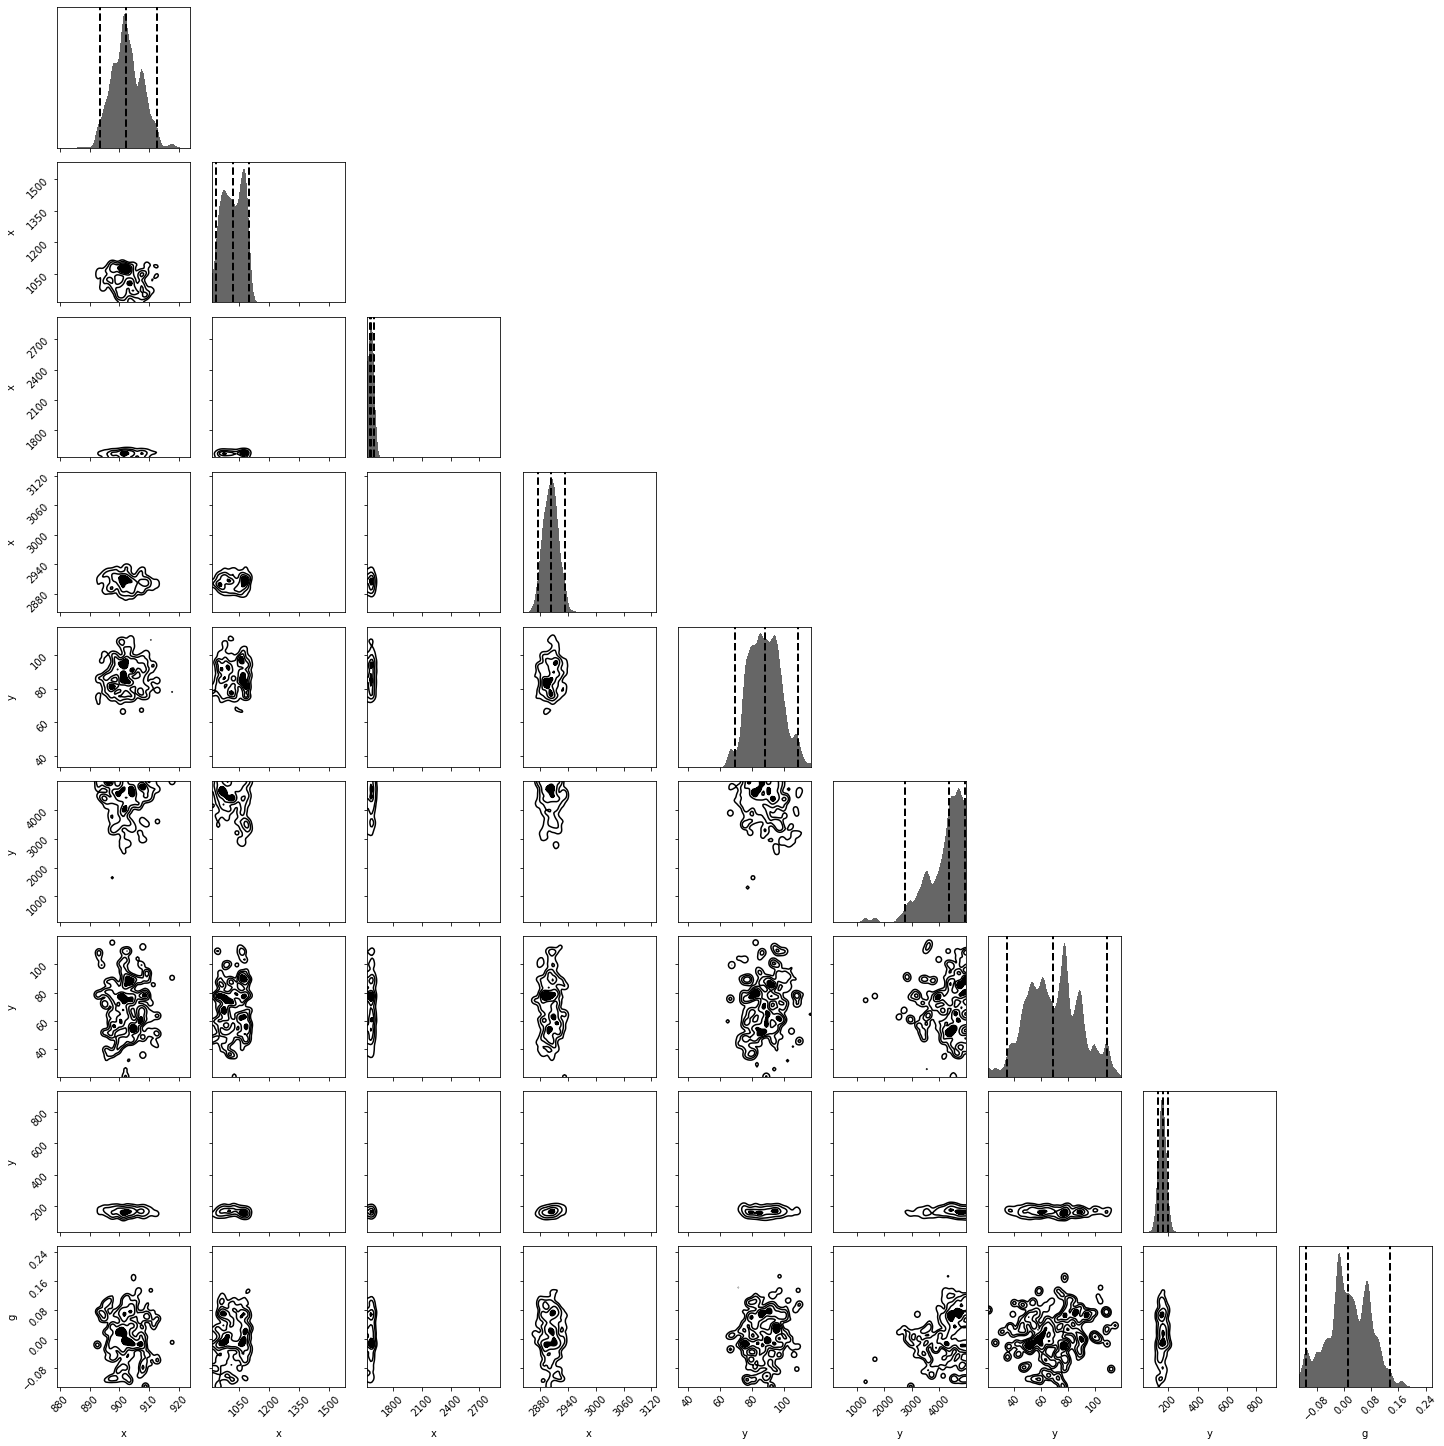

In [215]:
from lib import util

util.dyplot(results, (*["x"]*K, *["y"]*K, "g"), cornerplot=False); # (1.25, 1)

In [ ]:
# Load an example DGF to convolve h(t) with
t, u = np.load("vtr/prior/dgf.npy")
plot(t, u)
plot(t, cumsum(u)*(t[1]-t[0]))

[ 896. 1596. 2884.] [ 904.15 1572.43 2891.81]
[21.69 20.55 41.53] [44.12 38.13 96.06]
8.487566873035432 36.446760661579575 51.68047707906023 0.912518222997852
mu2(analytical) [msec] = 0.044741802967463655


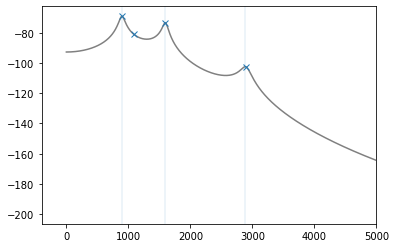

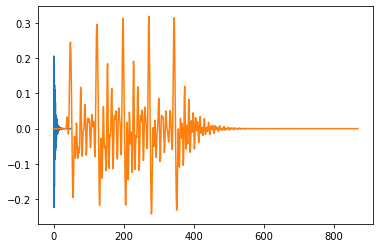

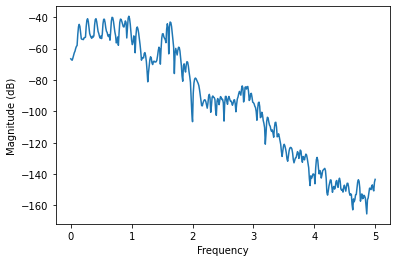

-48.76366141833654

In [226]:
from IPython.display import Audio
from vtr.prior.allpole import *

def unpack(params):
    x, y = np.split(params[:-1], 2)
    g = params[-1]
    return x, y, float(g)

def loglike_debug(
    params,
    f = sample['f'],
    F_true = sample['F'],
    B_true = sample['B'],
    sigma_F=constants.SIGMA_FB_REFERENCE_HZ,
    sigma_B=constants.SIGMA_FB_REFERENCE_HZ,
    tilt_target=constants.FILTER_SPECTRAL_TILT_DB,
    sigma_tilt=constants.SIGMA_TILT_DB,
    energy_target=constants.IMPULSE_RESPONSE_ENERGY_MSEC,
    sigma_energy=constants.SIGMA_IMPULSE_RESPONSE_ENERGY_MSEC
):
    x, y, g = unpack(params)
    
    # Calculate pole-zero transfer function
    power = transfer_function_power_dB(f, x, y, g)

    # Heuristically measure formants
    F, B = spectrum.get_formants_from_spectrum(f, power)

    # Heuristically measure spectral tilt starting from F3(true)
    cutoff = F_true[-1]
    tilt, interp_tilt = spectrum.fit_tilt(f, power, cutoff=cutoff, return_interp=True)
    
    # Calculate impulse response energy (in msec)
    energy = impulse_response_energy(x, y, g)
    
    F_err = np.sum(((F - F_true)/sigma_F)**2)
    B_err = np.sum(((B - B_true)/sigma_B)**2)
    tilt_err = ((tilt - tilt_target)/sigma_tilt)**2
    energy_err = ((energy - energy_target)/sigma_energy)**2
    
    # Print debug information
    print(np.round(F, 2), np.round(F_true, 2))
    print(np.round(B, 2), np.round(B_true, 2))
    print(F_err, B_err, tilt_err, energy_err)
    print("mu2(analytical) [msec] =", energy)
    
    # Plot stuff
    power = transfer_function_power_dB(f, x, y, g)
    plot(f, power, "grey")
    plot(f[f>cutoff], interp_tilt(f[f>cutoff]), label=f"fitted tilt {round(tilt,2)} dB/oct")
    plot(x, np.interp(x, f, power), 'x')
    for Fi in F: axvline(Fi, alpha=.1)
    xlim(None, 5000);
    title("Power spectrum capped at 5000 Hz")
    legend()
    show()
    
    t, dt = np.linspace(0., 50, int(50*constants.FS_KHZ), retstep=True) # msec
    h = allpole.impulse_response(t, x, y, g)
    plot(t, h, label="$h(t)$")
    d = convolve(h, u)*dt
    plot(d, label="$d(t) = u(t) * h(t)$")
    title("Example convolution in the time domain")
    legend()
    show()
    
    magnitude_spectrum(d, Fs=constants.FS_HZ, scale='dB')
    title("Power spectrum of $d(t)$ in the previous plot")
    show()
    
    display(Audio(d, rate=constants.FS_HZ, autoplay=True))
    
    return -(F_err + B_err + tilt_err + energy_err)/2

loglike_debug(util.resample_equal(results, 1).squeeze())
#loglike_debug(util.resample_equal(results, 1).squeeze())
#loglike_debug(util.resample_equal(results, 1).squeeze())

In [ ]:
from vtr.prior import polezero

x, y = unpack(util.resample_equal(results, 1).squeeze())

##
poles = core.make_poles(y, x)
c = core.pole_coefficients(poles)
a = real(c + conj(c))
b = real((1j)*(c - conj(c)))
ab_AP = np.concatenate((a, b))

S = polezero.overlap_matrix(x, y)
mu2_analytical_sec = ab_AP.T @ S @ ab_AP
print("mu2(analytical) [msec] =", mu2_analytical_sec*1000)

##

fs = 1000 # kHz
dt = 1/fs # msec
t = np.arange(0., 50, dt) # msec

h = allpole.impulse_response(t, x, y)
plot(t, h)

mu2 = np.dot(h, h)*dt
print("mu2 [msec] =", mu2)

##

f = sample['f']

power_db = allpole.transfer_function_power_dB(f, x, y)
power = 10**(power_db/10)

show()
plot(f, power)

power_PZ = polezero.transfer_function_power_dB(f, x, y, ab_AP, normalize_gain=True)
plot(f, 10**(power_PZ/10), label="PZ")

##
scipy.integrate.trapezoid(power, f)/1000*2

In [ ]:
util.resample_equal(results, 5)

In [ ]:
from dgf import bijectors

post_samples = util.resample_equal(results, 100)[:,2:]

post_bounds = np.array([
    [(100., 5000.)]*K + [(20., 5000.)]*K,
]).squeeze()

b = bijectors.fit_nonlinear_coloring_bijector(
    post_samples, post_bounds, 1234567890000000000
)

In [ ]:
xy = b.forward(randn(2*K))
x, y = np.split(xy, 2)

print(x)
print(y)

poles = core.make_poles(y, x) # rad kHz

f = constants.spectrum_frequencies()
power = allpole.transfer_function_power_dB(f/1000, poles)



plot(f, power, label="our implementation")
ylim(None, max(power)/1.1)

F, B = spectrum.get_formants_from_spectrum(f, power)
for xi in F: axvline(xi, color="grey")


def fit_tilt2(
    f, power_spectrum, return_interp=False
):
    """Estimate tilt in dB/oct by linear regression in log domain -- see tilt.ipynb
    
    May return NaN in exceptional cases if very badly conditioned (such
    as an upwardly curving power spectrum). This is very rare.
    """
    w = (f - f[0])/(f[-1] - f[0])
    print(w)
    f2 = np.log2(f)
    f2[0] = 0.
    
    a, b = np.polyfit(f2, power_spectrum, 1, w=w**2)
    
    if return_interp:
        interp_log = np.poly1d([a, b])
        def interp(f): return interp_log(np.log2(f))
        return a, interp
    else:
        return a

def fit_tilt3(
    f, power_spectrum, return_interp=False
):
    """Estimate tilt in dB/oct by linear regression in log domain -- see tilt.ipynb
    
    May return NaN in exceptional cases if very badly conditioned (such
    as an upwardly curving power spectrum). This is very rare.
    """
    f = f[1::5]
    power_spectrum = power_spectrum[1::5]
    
    a, b = np.polyfit(np.log(f), power_spectrum, 1)
    
    if return_interp:
        interp_log = np.poly1d([a, b])
        def interp(f): return interp_log(np.log2(f))
        return a, interp
    else:
        return a

    
tilt, interp = spectrum.fit_tilt(f, power, return_interp=True)
print(tilt)
plot(f[300:], interp(f[300:]))

tilt, interp = fit_tilt2(f, power, return_interp=True)
print(tilt)
plot(f[300:], interp(f[300:]), lw=3)

tilt, interp = spectrum.fit_tilt(f, power, F[-1], return_interp=True)
print(tilt)
plot(f[300:], interp(f[300:]), lw=3)

## Aggregate

In [ ]:
def posterior_of_fitted_FBT_values(K, numsamples=100):
    def process():
        for fit in allpole.yield_fitted_TFB_samples():
            if fit['K'] == K:
                yield util.resample_equal(fit['results'], numsamples)

    return np.vstack(list(process()))

In [ ]:
Kpost = 10

post_samples = np.vstack(posterior_of_fitted_FBT_values(Kpost))

In [ ]:
import corner

fig = corner.corner(
    post_samples,
    labels=("rho", "h", *["x"]*Kpost, *["y"]*Kpost),
    show_titles=True,
    smooth=1.
);

In [ ]:
from dgf import bijectors

theta = post_samples[:,2:]

post_bounds = np.array([
    [(100., 5000.)]*Kpost + [(20., 5000.)]*Kpost,
]).squeeze()

b = bijectors.fit_nonlinear_coloring_bijector(
    theta, post_bounds, 1234567890000000
)

In [ ]:
for i in range(10):
    xy = b.forward(randn(2*Kpost))
    x, y = np.split(xy, 2)

    poles = core.make_poles(y, x) # rad kHz
    
    t, dt = linspace(0, 50, 100000, retstep=True) # msec
    c = core.pole_coefficients(poles)
    K = len(poles)
    Y = real(2*c[None,:]*np.exp(t[:,None]*poles[None,:]))
    y = np.sum(Y, axis=1)
    plot(t, y)
    title("Impulse response")
    xlabel("time (msec)")
    show()

In [ ]:
for i in range(10):
    xy = b.forward(randn(2*Kpost))
    x, y = np.split(xy, 2)

    f = constants.spectrum_frequencies()
    power = allpole.transfer_function_power_dB(f, x, y)

    plot(f, power + i*30, label="our implementation")
    
    print(spectrum.number_of_peaks(f, power), spectrum.fit_tilt(f, power))
    #for xi in x: axvline(xi, color="grey")

In [ ]:
rho_mean, h_mean = mean(post_samples[:,:2], axis=0)
rho_mean, h_mean, std(post_samples[:,:2], axis=0)

In [ ]:
nopeaks = []
tilts = []

for i in range(10000):
    xy = b.forward(randn(2*Kpost))
    x, y = np.split(xy, 2)

    poles = core.make_poles(y, x) # rad kHz

    f = constants.spectrum_frequencies()
    power = allpole.transfer_function_power_dB(f/1000, poles)
    
    F, B = spectrum.get_formants_from_spectrum(f, power)
    nopeaks += [len(F)]
    tilts += [spectrum.fit_tilt(f, power)]

hist(nopeaks, bins=50);
show()
hist(tilts, bins=50);
axvline(allpole.analytical_tilt(Kpost))